# Experiments

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import itertools

from data_load import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score

##  New data

In [3]:
import pheme_data_load

In [4]:
pheme_data_dir = '../pheme-rnr-dataset/'

In [5]:
pheme_data = pheme_data_load.build_dataset(pheme_data_dir)

In [6]:
pheme_data.head()

,text,veracity
498235547685756928,"[black, teenage, boys, men, children, stop, re...",0
498248415223246848,"[mother, boy, killed, #ferguson, speaking, med...",0
498248648699150336,"[police, brought, large, gear, #ferguson]",0
498250100079341568,"[omg, wow, wow, police, brought, large, gear, ...",0
498251940997136384,"[see, citizens, enemies, police, brought, larg...",0


In [7]:
pheme_data.shape

(5802, 2)

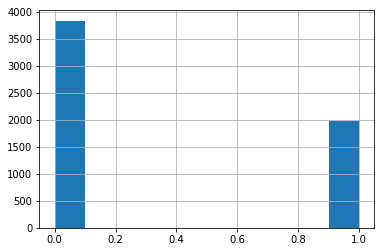

In [8]:
pheme_data.veracity.hist()

## Competition data

### Load

In [9]:
data_dir = '../rumoureval-2019-training-data'

In [10]:
a_train_data, a_dev_data, \
b_train_data, b_dev_data, data_struct = build_dataset(data_dir)

In [11]:
a_train_data.head()

,text,sqdc
498280920227794945,[wow],3.0
498282494387843072,"[unbelieveable, r, double, digits, white, men,...",3.0
498283789744103424,"[emmett, till, visiting, family, murdered, dec...",3.0
498323335965868032,"[mike, brown, staying, grandmother, summer, li...",0.0
498432131669192704,"[cool, darkskinned, man, crime, element, villa...",3.0


In [12]:
b_train_data.head()

,text,support,deny,query,comment,support,deny,query,veracity
18dmb4,"[even, ants, eat, aspartame]",1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0
1hzz6y,"[cancer, fungus, idea, 60s, apparently, receiv...",0.0,0.0,1.0,0.0,0.000000,0.000000,0.100000,1.0
1i8cy7,"[repost, til, financial, guru, robert, kiyosak...",0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0
1i8ljs,"[true, member, media, doj, longer, needs, warr...",0.0,0.0,1.0,0.0,0.000000,0.181818,0.090909,2.0
22o24j,"[much, truth, statement, 15, 20, actually, sol...",0.0,0.0,1.0,0.0,0.015152,0.151515,0.015152,2.0


In [13]:
a_dev_data.shape

(1485, 2)

In [14]:
b_train_data.shape

(327, 9)

In [15]:
b_dev_data.shape

(38, 9)

#### Concat populations

In [16]:
veracity_data = pd.concat([b_train_data, b_dev_data], axis=0)

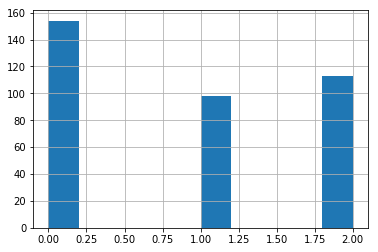

In [20]:
veracity_data.veracity.hist()

In [19]:
stance_data = pd.concat([a_train_data, a_dev_data], axis=0)

#### Unverified remove

In [54]:
veracity_data_tf = veracity_data.loc[veracity_data.loc[:, 'veracity'].isin([0, 1])]

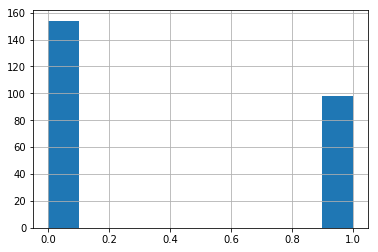

In [55]:
veracity_data_tf.veracity.hist()

### Statistics

#### Labels distributions

In [13]:
word_fd = nltk.probability.FreqDist(list(itertools.chain.from_iterable(veracity_data.text)))

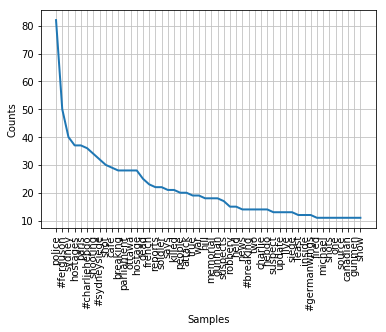

In [14]:
word_fd.plot(50)

## TF-IDF

### Vectorization

In [16]:
tf_idf_vectorizer = TfidfVectorizer(lowercase=False, token_pattern=r'[^\s]+')

In [17]:
tf_idf = tf_idf_vectorizer.fit_transform([' '.join(tweet) for tweet in veracity_data.text])

Squeeze

In [19]:
svd = TruncatedSVD(n_components=200)
tf_idf_svd = svd.fit_transform(tf_idf)

### Train/test

In [78]:
X = np.hstack((tf_idf_svd, veracity_data.iloc[:, range(1, 8)].values))

In [79]:
X_train, X_test, \
y_train, y_test = train_test_split(X, veracity_data.veracity)

### Log-reg

In [80]:
model = LogisticRegression()

In [81]:
model.fit(X_train, y_train)

/home/twlvth/Documents/venvs/nlp_mipt/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/twlvth/Documents/venvs/nlp_mipt/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [82]:
y_pred = model.predict(X_test)

In [83]:
f1_score(y_test, y_pred, average='micro')

0.6630434782608695

In [84]:
f1_score(y_test, y_pred, average='weighted')

0.6349793469358687

### KNN

In [85]:
model = KNeighborsClassifier()

In [86]:
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [87]:
y_pred = model.predict(X_test)

In [88]:
f1_score(y_test, y_pred, average='weighted')

0.6549702961265237

## ELMO

In [36]:
from allennlp.commands.elmo import ElmoEmbedder
from allennlp.modules.elmo import Elmo, batch_to_ids
import torch
import torch.utils.data
from torch import nn
import torch.nn.functional as F

#### Pre-trained with KNN

In [8]:
elmo = ElmoEmbedder()

12/12/2018 02:48:24 - INFO - allennlp.commands.elmo -   Initializing ELMo.


In [9]:
batch_emb = elmo.embed_batch(batch=list(veracity_data.text))

/home/twlvth/Documents/venvs/nlp_mipt/lib/python3.6/site-packages/allennlp/nn/util.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  index_range = sequence_lengths.new_tensor(torch.arange(0, len(sequence_lengths)))


In [10]:
batch_emb_1 = np.array([sent_emb.sum(0).mean(0) for sent_emb in batch_emb])

In [11]:
batch_emb_1.shape

(365, 1024)

In [55]:
X = np.hstack((batch_emb_1, veracity_data.iloc[:, range(1, 8)].values))
# X = batch_emb_1

In [18]:
X_train, X_test, \
y_train, y_test = train_test_split(X, veracity_data.veracity)

NameError: name 'X' is not defined

In [57]:
model = KNeighborsClassifier()

In [58]:
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
y_pred = model.predict(X_test)

In [61]:
f1_score(y_test, y_pred, average='micro')

0.6304347826086957

In [62]:
f1_score(y_test, y_pred, average='weighted')

0.620156330103682

#### Trained with CNN

In [56]:
veracity_train, \
veracity_test = train_test_split(veracity_data_tf, random_state=42)
pheme_train, \
pheme_test = train_test_split(pheme_data, random_state=42)

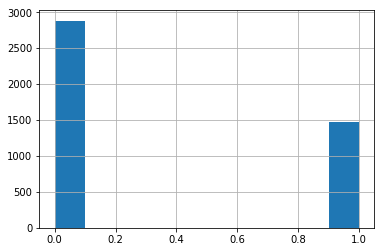

In [57]:
pheme_train.veracity.hist()

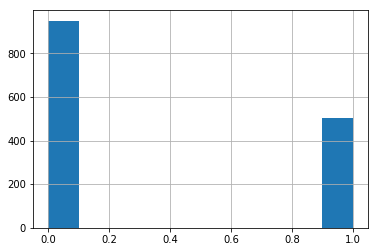

In [58]:
pheme_test.veracity.hist()

In [59]:
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

In [60]:
class ClassCNN(nn.Module):
    def __init__(self, elmo_layers=3, emb_size=1024, filters=2):
        super().__init__()
        self.filters = filters
        
        self.elmo = Elmo(options_file, weight_file, elmo_layers)
        self.elmo_params = nn.Parameter(torch.rand(elmo_layers), requires_grad=True)
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, filters, (2, emb_size)),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1))
    
        self.conv_2 = nn.Sequential(
            nn.Conv2d(1, filters, (3, emb_size)),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1))
        
        self.conv_3 = nn.Sequential(
            nn.Conv2d(1, filters, (4, emb_size)),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1))
        
        self.final = nn.Sequential(
            nn.Dropout(),
            nn.Linear(3 * filters, 2))
        
    def forward(self, batch):        
        batch_size = batch.shape[0]
        
        # batch_size x seq_len x emb_size
        X = torch.stack(self.elmo(batch)['elmo_representations'])
        X = torch.sum(self.elmo_params.view(len(self.elmo_params), 1, 1, 1) * X, dim=0)
        
        
        # batch_size x channels == 1 x seq_len x emb_size
        X = X.unsqueeze(1)
        
        # batch_size x channels == filters x 1 x 1
        X_3 = self.conv_1(X)
        # batch_size x channels == filters x 1 x 1
        X_4 = self.conv_2(X)
        # batch_size x channels == filters x 1 x 1
        X_5 = self.conv_3(X)
        
        # batch_size x 3 * filters
        X = torch.cat([X_3.view(batch_size, self.filters), 
                       X_4.view(batch_size, self.filters), 
                       X_5.view(batch_size, self.filters)], dim=-1)
        
        # batch_size x classes == 2
        X = self.final(X)
                
        return X        

In [61]:
def get_loader(X, y, batch_size=16):
    data = torch.utils.data.TensorDataset(X, torch.tensor(y, dtype=torch.int32).long())
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    return data_loader

No additional features

In [62]:
def proba_to_class(probas, unv_int=0.05):
    if proba > 0.5 + unv_int:
        return 0
    elif proba < 0.5 - unv_int:
        return 1
    else:
        return 2

def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
    return

def evaluate_loss_acc(loader, model, device, criterion, pre_train=False):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    labels_pred = []
    labels_true = []
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            predicted = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
#             if pre_train:
#                 predicted = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
#             else:
#                 predicted = F.softmax(outputs, dim=-1)[:, 0]
#                 predicted = [proba_to_class(proba) for proba in predicted]
            labels_true += list(labels.cpu().numpy())
            labels_pred += list(predicted.cpu().numpy())
    loss = criterion(outputs, labels)
    return loss, accuracy_score(labels_true, labels_pred), f1_score(labels_true, labels_pred, average='weighted')
    
def train(model, opt, train_loader, test_loader, criterion, n_epochs, \
          device, verbose=True, pre_train=False):
    train_log, train_acc_log, train_f1_log = [], [], []
    val_log, val_acc_log, val_f1_log = [], [], []
    
    opt = opt(model.parameters())
    lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                   step_size=3,
                                                   gamma=1)

    for epoch in range(n_epochs):
        lr_scheduler.step()
        
        train_epoch(model, opt, train_loader, criterion, device)
        train_loss, train_acc, train_f1 = evaluate_loss_acc(train_loader, 
                                                            model, 
                                                            device, 
                                                            criterion,
                                                            pre_train)
        val_loss, val_acc, val_f1 = evaluate_loss_acc(test_loader, 
                                                      model, 
                                                      device, 
                                                      criterion,
                                                      pre_train)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)
        train_f1_log.append(train_f1)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)
        val_f1_log.append(val_f1)
        
        if verbose:
             print(('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f, ' + 'F1 (train/test): %.4f/%.4f')
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc, train_f1, val_f1))
            
    return train_log, train_acc_log, train_f1_log, val_log, val_acc_log, val_f1_log

In [63]:
veracity_train_loader = get_loader(batch_to_ids(veracity_train.text), veracity_train.veracity, batch_size=16)
veracity_test_loader = get_loader(batch_to_ids(veracity_test.text), veracity_test.veracity, batch_size=16)
pheme_train_loader = get_loader(batch_to_ids(pheme_train.text), pheme_train.veracity, batch_size=32)
pheme_test_loader = get_loader(batch_to_ids(pheme_test.text), pheme_test.veracity, batch_size=32)

In [69]:
# batch x seq_len x smth
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
elmo_nn = ClassCNN(elmo_layers=3, filters=2)
elmo_nn = elmo_nn.to(device)

12/16/2018 01:55:36 - INFO - allennlp.modules.elmo -   Initializing ELMo


In [71]:
train(elmo_nn, torch.optim.Adam, pheme_train_loader, pheme_test_loader, F.cross_entropy, 6, device, pre_train=True)

Epoch [1/6], Loss (train/test): 0.3945/0.3169, Acc (train/test): 0.8649/0.8229, F1 (train/test): 0.8621/0.8180
Epoch [2/6], Loss (train/test): 0.3380/0.2730, Acc (train/test): 0.8764/0.8249, F1 (train/test): 0.8731/0.8196
Epoch [3/6], Loss (train/test): 0.3286/0.2503, Acc (train/test): 0.8943/0.8449, F1 (train/test): 0.8927/0.8425
Epoch [4/6], Loss (train/test): 0.3403/0.3157, Acc (train/test): 0.8901/0.8387, F1 (train/test): 0.8882/0.8357
Epoch [5/6], Loss (train/test): 0.3101/0.2614, Acc (train/test): 0.8982/0.8367, F1 (train/test): 0.8969/0.8346
Epoch [6/6], Loss (train/test): 0.2558/0.3208, Acc (train/test): 0.9023/0.8208, F1 (train/test): 0.9003/0.8167


([tensor(0.3945, device='cuda:0'),
  tensor(0.3380, device='cuda:0'),
  tensor(0.3286, device='cuda:0'),
  tensor(0.3403, device='cuda:0'),
  tensor(0.3101, device='cuda:0'),
  tensor(0.2558, device='cuda:0')],
 [0.8648586531831762,
  0.8763502643070559,
  0.894277177660308,
  0.8901401976557113,
  0.898184325442427,
  0.9023213054470237],
 [0.8621309846426926,
  0.8731141242371713,
  0.8927312308993075,
  0.888197286622491,
  0.8968784412269117,
  0.9002931913857957],
 [tensor(0.3169, device='cuda:0'),
  tensor(0.2730, device='cuda:0'),
  tensor(0.2503, device='cuda:0'),
  tensor(0.3157, device='cuda:0'),
  tensor(0.2614, device='cuda:0'),
  tensor(0.3208, device='cuda:0')],
 [0.822880771881461,
  0.8249483115093039,
  0.844934527911785,
  0.8387319090282563,
  0.8366643694004136,
  0.8208132322536182],
 [0.8179767456756573,
  0.8196469219779356,
  0.8425283720435294,
  0.8356628501198529,
  0.8346269792747469,
  0.8166798242196891])

In [72]:
train(elmo_nn, torch.optim.Adam, veracity_train_loader, veracity_test_loader, F.cross_entropy, 10, device, pre_train=False)

Epoch [1/10], Loss (train/test): 0.8468/0.6180, Acc (train/test): 0.5450/0.5714, F1 (train/test): 0.5087/0.5149
Epoch [2/10], Loss (train/test): 0.6822/0.6193, Acc (train/test): 0.6243/0.6190, F1 (train/test): 0.5219/0.5121
Epoch [3/10], Loss (train/test): 0.6468/0.6246, Acc (train/test): 0.6296/0.6349, F1 (train/test): 0.5179/0.5218
Epoch [4/10], Loss (train/test): 0.6429/0.6294, Acc (train/test): 0.6349/0.6349, F1 (train/test): 0.5210/0.5218
Epoch [5/10], Loss (train/test): 0.6421/0.6313, Acc (train/test): 0.6349/0.6349, F1 (train/test): 0.5210/0.5218
Epoch [6/10], Loss (train/test): 0.6422/0.6268, Acc (train/test): 0.6402/0.6349, F1 (train/test): 0.5242/0.5218
Epoch [7/10], Loss (train/test): 0.6404/0.6229, Acc (train/test): 0.6455/0.6349, F1 (train/test): 0.5349/0.5218
Epoch [8/10], Loss (train/test): 0.6396/0.6207, Acc (train/test): 0.6455/0.6349, F1 (train/test): 0.5349/0.5218
Epoch [9/10], Loss (train/test): 0.6329/0.6202, Acc (train/test): 0.6667/0.6349, F1 (train/test): 0.5758

([tensor(0.8468, device='cuda:0'),
  tensor(0.6822, device='cuda:0'),
  tensor(0.6468, device='cuda:0'),
  tensor(0.6429, device='cuda:0'),
  tensor(0.6421, device='cuda:0'),
  tensor(0.6422, device='cuda:0'),
  tensor(0.6404, device='cuda:0'),
  tensor(0.6396, device='cuda:0'),
  tensor(0.6329, device='cuda:0'),
  tensor(0.5614, device='cuda:0')],
 [0.544973544973545,
  0.6243386243386243,
  0.6296296296296297,
  0.6349206349206349,
  0.6349206349206349,
  0.6402116402116402,
  0.6455026455026455,
  0.6455026455026455,
  0.6666666666666666,
  0.6772486772486772],
 [0.508687543775263,
  0.5218813375644088,
  0.5178660203827988,
  0.5210120399993818,
  0.5210120399993818,
  0.5241568308234974,
  0.5348957489849069,
  0.5348957489849069,
  0.5757538629092642,
  0.5950348891926888],
 [tensor(0.6180, device='cuda:0'),
  tensor(0.6193, device='cuda:0'),
  tensor(0.6246, device='cuda:0'),
  tensor(0.6294, device='cuda:0'),
  tensor(0.6313, device='cuda:0'),
  tensor(0.6268, device='cuda:0'),

In [80]:
train(elmo_nn, torch.optim.Adam, train_loader, test_loader, F.cross_entropy, 20, device)

Epoch [1/30], Loss (train/test): 1.1042/1.0153, Acc (train/test): 68.4982/32.6087
Epoch [2/30], Loss (train/test): 0.5404/0.9558, Acc (train/test): 76.9231/61.9565
Epoch [3/30], Loss (train/test): 0.2281/0.9429, Acc (train/test): 86.4469/59.7826
Epoch [4/30], Loss (train/test): 0.1096/0.9408, Acc (train/test): 91.9414/57.6087
Epoch [5/30], Loss (train/test): 0.0301/0.9666, Acc (train/test): 95.2381/60.8696
Epoch [6/30], Loss (train/test): 0.0098/0.8762, Acc (train/test): 95.6044/67.3913
Epoch [7/30], Loss (train/test): 0.0109/0.9750, Acc (train/test): 97.4359/68.4783
Epoch [8/30], Loss (train/test): 0.0091/0.9994, Acc (train/test): 98.9011/58.6957


KeyboardInterrupt: 

### ULMfit (didn't work, dunno why)

In [5]:
from fastai.text import *
from fastai import *

In [6]:
veracity_train, \
veracity_test = train_test_split(veracity_data)

In [69]:
veracity_train.shape

(273, 9)

In [67]:
veracity_test.shape

(92, 9)

In [10]:
data_lm = TextLMDataBunch.from_df(path='ULMfit', 
                                  train_df=veracity_train,
                                  valid_df=veracity_test,
                                  text_cols='text',
                                  label_cols='veracity')

In [11]:
data_clas = TextClasDataBunch.from_df(path='ULMfit', 
                                      train_df=veracity_train,
                                      valid_df=veracity_test,
                                      text_cols='text',
                                      label_cols='veracity',
                                      vocab=data_lm.train_ds.vocab, 
                                      bs=32)

In [12]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1)

In [13]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,6.714386,6.001719,0.357143


In [14]:
learn.save_encoder('fit_encoder')

In [15]:
learn = text_classifier_learner(data_clas)
learn.load_encoder('fit_encoder')

In [16]:
data_clas.show_batch()

text,target
xxbos xxfld 1 xxunk xxunk hostage - taker # sydney xxunk # xxunk xxunk suspect xxunk - xxunk killing xxunk xxunk xxunk http : / / t.co / xxunk http : / / t.co / xxunk,0.0
xxbos xxfld 1 name # ferguson cop xxunk released xxunk xxunk police chief says http : / / t.co / xxunk xxunk xxunk xxunk ap http : / / t.co / xxunk,2.0
xxbos xxfld 1 xxunk xxunk xxunk xxunk hillary xxunk xxunk xxunk xxunk xxunk xxunk 4 pm 6 pm xxunk https : / / t.co / xxunk # trump # xxunk,1.0
xxbos xxfld 1 xxunk xxunk hostages may held xxunk # lindt café local reports http : / / t.co / 1zlzkdjvsf # sydneysiege http : / / t.co / xxunk,1.0
xxbos xxfld 1 hostage - taker paris store xxunk release # xxunk police xxunk xxunk says http : / / t.co / xxunk http : / / t.co / xxunk,2.0


In [17]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1200])